In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as s
import matplotlib.patches as mpatches
import math
import csv
import os
import opendssdirect as dss
from opendssdirect.utils import run_command
import types
import matplotlib.pyplot as plt
import inspect

In [2]:
run_command("Compile 'microgrid.dss'")

''

# LOADS

In [3]:
# Loads
LOADS_ENABLED='Yes'
dss.run_command('New Load.{name} Bus1={bus} Phases=3 Conn=wye Model=1 kV=0.4  pf=0.98  daily={daily} Vminpu=0.5 Vmaxpu=3 enabled={enabled}'.format(
    name='officeBuilding',
    bus='712',
    daily='officeLoad',
    enabled=LOADS_ENABLED
))
dss.run_command('New Load.{name} Bus1={bus} Phases=3 Conn=wye Model=1 kV=0.4  pf=0.98  daily={daily} Vminpu=0.5 Vmaxpu=3 enabled={enabled}'.format(
    name='industrialPark',
    bus='705',
    daily='industrialParkLoad',
    enabled=LOADS_ENABLED
))
dss.run_command('New Load.{name} Bus1={bus} Phases=3 Conn=wye Model=1 kV=0.4  pf=0.98  daily={daily} Vminpu=0.5 Vmaxpu=3 enabled={enabled}'.format(
    name='shops',
    bus='713',
    daily='shopsLoad',
    enabled=LOADS_ENABLED
))

''

# GENERATORS

In [4]:
GENERATORS_ENABLED='Yes'
dss.run_command('New Generator.{name} Bus1={bus} Phases=3 Conn=wye Model=1 kV=0.4  pf=0.98 kw={kw} daily={daily} Vminpu=0.5 Vmaxpu=3 enabled={enabled}'.format(
    name='fve',
    bus='705',
    daily='fveLoad',
    enabled=GENERATORS_ENABLED,
    kw=0.02
))
dss.run_command('New Generator.{name} Bus1={bus} Phases=3 Conn=wye Model=1 kV=0.4  pf=0.98 kw={kw} daily={daily} Vminpu=0.5 Vmaxpu=3 enabled={enabled}'.format(
    name='mve',
    bus='701',
    daily='mveLoad',
    enabled=GENERATORS_ENABLED,
    kw=0.06
))
dss.run_command('New Generator.{name} Bus1={bus} Phases=3 Conn=wye Model=1 kV=0.4  pf=0.98 kw={kw} daily={daily} Vminpu=0.5 Vmaxpu=3 enabled={enabled}'.format(
    name='wpg',
    bus='714',
    daily='wpgLoad',
    enabled=GENERATORS_ENABLED,
    kw=0.06
))

''

# BATERY

In [5]:
dss.run_command('new storage.baterry bus=701 kV=0.4 Phases=3 kwRated=10 kWhrated=100 kWhstored=0 vminpu=0.80 vmaxpu=1.20  %reserve=1  %effcharge=100   %effdischarge=100   %IdlingkW=0   enabled=yes')
#dss.run_command('new StorageController.scbattery element=Line.L1  Terminal=1 Elementlist=[baterry]  modedischarge=Peakshave kWTarget=20 modeCharge=PeakShaveLow kWTargetlow=0   InhibitTime=1')
dss.run_command('''
        New LoadShape.SC_loadshape interval=1 npts=96 mult=[-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
        ''')
dss.run_command('''
New StorageController.SC element=Line.L1 terminal=1 modedis=loadshape daily=SC_loadshape %rateCharge=100 %reserve=20 eventlog=yes
''')

''

# MONITORS

In [6]:
dss.run_command('New Monitor.{name}  element=Line.{elementname}  ppolar=no mode=65 enabled={enabled}'.format(
    name='trafo',
    elementname='L1',
    enabled='Yes'
))
dss.run_command('New Monitor.baterry  element=storage.baterry   mode=3')

''

In [7]:
dss.run_command('Set controlmode=time')
dss.run_command('Set mode=daily ')
dss.run_command('Set stepsize=15m')
dss.run_command('Set number=96')

''

In [8]:
dss.run_command('Solve');

In [9]:
x = dss.run_command('Export monitor object=trafo')
batery = dss.run_command('Export monitor object=baterry')

In [10]:
batery

'/Users/williambrach/Developer/Microgrid-cerebrum/opendss/baterka_Mon_baterry_1.csv'

In [11]:
df = pd.read_csv(x)
batery = pd.read_csv(batery)

In [15]:
batery.head(50)

,hour,t(sec),kWh,State,kWOut,kWIn,kvarOut,DCkW,kWTotalLosses,kWInvLosses,...,VV Oper,VW Oper,DRC Oper,VV_DRC Oper,WP Oper,WV Oper,kWDesired,kW VW Limit,Limit kWOut Function,kVA Exceeded
0,0,900.0,0.00000,0,0.00000,0.00000,0.000000e+00,0.00000,0,0,...,9999,9999,9999,9999,9999,9999,0,9999,10,0
1,0,1800.0,0.00000,0,0.00000,0.00000,0.000000e+00,0.00000,0,0,...,9999,9999,9999,9999,9999,9999,0,9999,10,0
2,0,2700.0,0.00000,0,0.00000,0.00000,0.000000e+00,0.00000,0,0,...,9999,9999,9999,9999,9999,9999,-10,9999,10,0
3,1,0.0,0.00000,0,0.00000,0.00000,0.000000e+00,0.00000,0,0,...,9999,9999,9999,9999,9999,9999,-10,9999,10,0
4,1,900.0,0.00000,0,0.00000,0.00000,0.000000e+00,0.00000,0,0,...,9999,9999,9999,9999,9999,9999,-10,9999,10,0
5,1,1800.0,0.00000,0,0.00000,0.00000,0.000000e+00,0.00000,0,0,...,9999,9999,9999,9999,9999,9999,-10,9999,10,0
6,1,2700.0,0.00000,0,0.00000,0.00000,0.000000e+00,0.00000,0,0,...,9999,9999,9999,9999,9999,9999,-10,9999,10,0
7,2,0.0,0.00000,-1,0.00000,10.00000,-2.865730e-05,-10.00000,0,0,...,9999,9999,9999,9999,9999,9999,-10,9999,10,1
8,2,900.0,2.50001,-1,0.00000,9.99999,5.297350e-06,-9.99999,0,0,...,9999,9999,9999,9999,9999,9999,-10,9999,10,1
9,2,1800.0,5.00001,-1,0.00000,10.00000,-4.923020e-06,-10.00000,0,0,...,9999,9999,9999,9999,9999,9999,-10,9999,10,1


299.99969


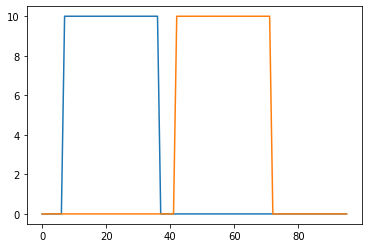

In [13]:
print(batery['kWIn'].sum())
batery['kWIn'].plot()
batery['kWOut'].plot()
plt.show()

In [14]:
kw = df[' P1 (kW)'][2*96:(2+1)*96]
b = batery['kWOut'][2*96:(2+1)*96]
b_in = batery['kWIn'][2*96:(2+1)*96]
b_in[1:5] = 50
b_in.index = range(0,96)
b.index = range(0,96)
kw.index = range(0,96)
plus = kw[kw > 0]
minus = kw[kw <= 0].multiply(-1)
b = b.multiply(1)

KeyError: ' P1 (kW)'

In [ ]:


p1 = plt.fill_between(plus.index,plus, 0, alpha=0.5,color="red")
p2 = plt.fill_between(minus.index[:34],minus[:34], 0, alpha=0.5,color="green")
p3 = plt.fill_between(minus.index[35:],minus[35:], 0, alpha=0.5,color="green")
p4 = plt.fill_between(b.index[36:54],b[36:54],alpha=1,facecolor="red",edgecolor="darkred", linewidth=1.0)

p6 = plt.fill_between(b_in.index[80:],b_in[80:],alpha=1,facecolor="green",edgecolor="darkgreen", linewidth=1.0)
p5 = plt.fill_between(b_in.index[:6],b_in[:6],alpha=1,facecolor="green",edgecolor="darkgreen", linewidth=1.0)

red_patch = mpatches.Patch(color='red',alpha=0.5, label='Chýbajúca elektrická energia')
green_patch = mpatches.Patch(color='green',alpha=0.5, label='Prebytočná elektrická energia')
darkgreen_patch = mpatches.Patch(color='darkgreen', label='Nabíjanie akumulátora')
darkred_patch = mpatches.Patch(color='darkred', label='Vybíjanie akumulátora')
plt.legend(handles=[red_patch,green_patch, darkgreen_patch, darkred_patch],bbox_to_anchor = (1.55, 0.6))

plt.xlabel("Meranie")
plt.ylabel("Výkon (kW)")
plt.title("Denný priebeh s pridaním akumulátora")
plt.savefig("graf_2.png")
plt.show()
